In [6]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats, mean

from scipy.stats import sem, t
import numpy as np
import random

from matplotlib import pyplot as plt

confidence = 0.95

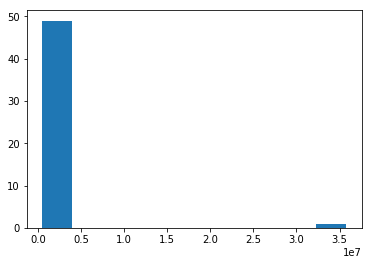

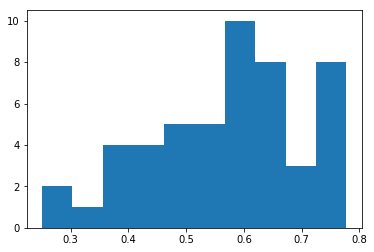

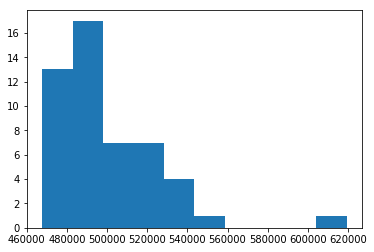

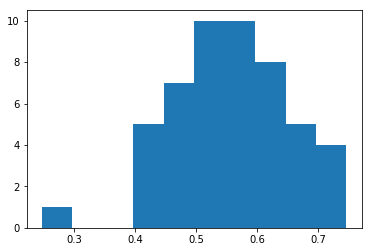

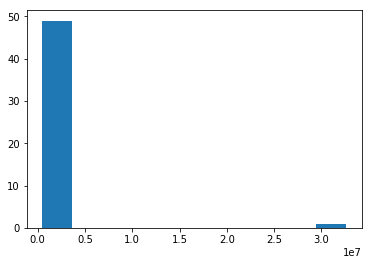

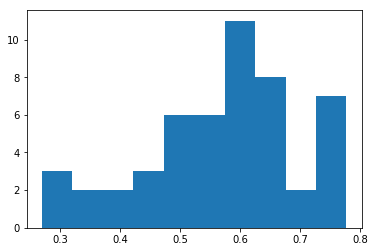

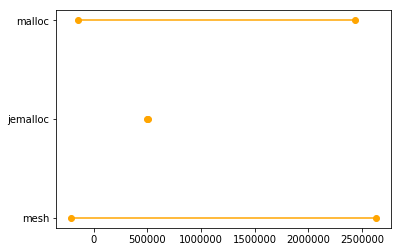

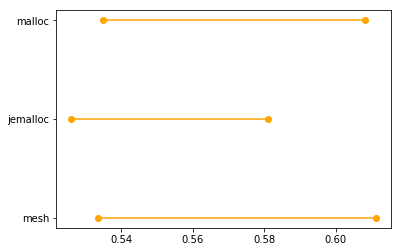

In [7]:
df = pd.read_csv('larson_results.csv')
tlb_data_dict = {'category':[],'lower':[],'upper':[]}
cache_data_dict = {'category':[],'lower':[],'upper':[]}


for lib,grp in df.groupby('memlib'):
    if lib == "/usr/lib/x86_64-linux-gnu/libjemalloc.so":
        tlb_data_dict['category'].append("jemalloc")
        cache_data_dict['category'].append("jemalloc")
    elif lib=="/usr/lib/libmesh.so":
        tlb_data_dict['category'].append("mesh")
        cache_data_dict['category'].append("mesh")
    elif  lib=="malloc":
        tlb_data_dict['category'].append(lib)
        cache_data_dict['category'].append(lib)

    tlb = grp['dTLB-load-misses']+grp['iTLB-load-misses']+grp['dTLB-store-misses']
    cache = grp['cache-misses']/grp['cache-references']
    
    plt.hist(tlb)
    plt.show()
    
    plt.hist(cache)
    plt.show()

    
    tlb_ci = t.interval(0.95, len(tlb)-1, loc=np.mean(tlb), scale=sem(tlb))
    cache_ci = t.interval(0.95, len(cache)-1, loc=np.mean(cache), scale=sem(cache))
    tlb_data_dict['lower'].append(tlb_ci[0])
    tlb_data_dict['upper'].append(tlb_ci[1])
    cache_data_dict['lower'].append(cache_ci[0])
    cache_data_dict['upper'].append(cache_ci[1])
    
tlb_dataset = pd.DataFrame(tlb_data_dict)
cache_dataset = pd.DataFrame(cache_data_dict)

for lower,upper,y in zip(tlb_dataset['lower'],tlb_dataset['upper'],range(len(tlb_dataset))):
    plt.plot((lower,upper),(y,y),'ro-',color='orange')
plt.yticks(range(len(tlb_dataset)),list(tlb_dataset['category']))
plt.show()

for lower,upper,y in zip(cache_dataset['lower'],cache_dataset['upper'],range(len(cache_dataset))):
    plt.plot((lower,upper),(y,y),'ro-',color='orange')
plt.yticks(range(len(cache_dataset)),list(cache_dataset['category']))
plt.show()

In [8]:
import numpy as np
def bootstrap_ci(df, variable, classes, repetitions = 1000, alpha = 0.05, random_state=None): 
    
    df = df[[variable, classes]]
    bootstrap_sample_size = len(df) 
    
    mean_diffs = []
    for i in range(repetitions):
        bootstrap_sample = df.sample(n = bootstrap_sample_size, replace = True, random_state = random_state)
        mean_diff = bootstrap_sample.groupby(classes).mean().iloc[1,0] - bootstrap_sample.groupby(classes).mean().iloc[0,0]
        mean_diffs.append(mean_diff)# confidence interval
    left = np.percentile(mean_diffs, alpha/2*100)
    right = np.percentile(mean_diffs, 100-alpha/2*100)# point estimate
    point_est = df.groupby(classes).mean().iloc[1,0] - df.groupby(classes).mean().iloc[0,0]
    print('Point estimate of difference between means:', round(point_est,2))
    print((1-alpha)*100,'%','confidence interval for the difference between means:', (round(left,2), round(right,2)))

In [9]:
bootstrap_ci(df, 'dTLB-load-misses', 'memlib')

Point estimate of difference between means: -2440.44
95.0 % confidence interval for the difference between means: (-9941.3199999999997, 4622.6000000000004)


In [10]:
def draw_bs_replicates(data,func,size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data,size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

files = ["mysql_results", "larson_results", "binarytree_results", "redis_results"]

In [13]:
for file in files:
    df = pd.read_csv(file+'.csv')
    tlb_data_dict = {'category':[],'lower':[],'upper':[], 'mean':[]}
    cache_data_dict = {'category':[],'lower':[],'upper':[], 'mean':[]}
    plt.close()

    for lib,grp in df.groupby('memlib'):
        if lib == "/usr/lib/x86_64-linux-gnu/libjemalloc.so":
            tlb_data_dict['category'].append("jemalloc")
            cache_data_dict['category'].append("jemalloc")
        elif lib=="/usr/lib/libmesh.so":
            tlb_data_dict['category'].append("mesh")
            cache_data_dict['category'].append("mesh")
        elif  lib=="malloc":
            tlb_data_dict['category'].append(lib)
            cache_data_dict['category'].append(lib)

        tlb = grp['dTLB-load-misses']+grp['iTLB-load-misses']+grp['dTLB-store-misses']
        cache = grp['cache-misses']/grp['cache-references']

        bs_replicates_tlb = draw_bs_replicates(tlb,np.mean,50000)
        conf_interval_tlb = np.percentile(bs_replicates_tlb,[2.5,97.5])
        print("The confidence interval tlb: ",conf_interval_tlb)

        bs_replicates_cache = draw_bs_replicates(cache,np.mean,50000)
        conf_interval_cache = np.percentile(bs_replicates_cache,[2.5,97.5])
        print("The confidence interval cache: ",conf_interval_cache)

        tlb_data_dict['mean'].append(np.mean(bs_replicates_tlb))
        tlb_data_dict['lower'].append(conf_interval_tlb[0])
        tlb_data_dict['upper'].append(conf_interval_tlb[1])
        cache_data_dict['mean'].append(np.mean(bs_replicates_cache))
        cache_data_dict['lower'].append(conf_interval_cache[0])
        cache_data_dict['upper'].append(conf_interval_cache[1])



    tlb_dataset = pd.DataFrame(tlb_data_dict)
    cache_dataset = pd.DataFrame(cache_data_dict)

    for lower,upper,mean,y in zip(tlb_dataset['lower'],tlb_dataset['upper'],tlb_dataset['mean'],range(len(tlb_dataset))):
        plt.plot((lower,mean,upper),(y,y,y),'bo-',color='orange')
    plt.yticks(range(len(tlb_dataset)),list(tlb_dataset['category']))
    #plt.show()
    plt.savefig(str(file+"_tlb.pdf"), format="pdf")
    plt.close()

    for lower,upper,mean,y in zip(cache_dataset['lower'],cache_dataset['upper'],cache_dataset['mean'],range(len(cache_dataset))):
        plt.plot((lower,mean,upper),(y,y,y),'bo-',color='orange')
    plt.yticks(range(len(cache_dataset)),list(cache_dataset['category']))
    #plt.show()
    plt.savefig(str(file+"_cache.pdf"), format="pdf")
    plt.close()

The confidence interval tlb:  [ 16475251.1576087   17558760.29728261]
The confidence interval cache:  [ 0.1104686   0.11489368]
The confidence interval tlb:  [ 15968218.73265306  17060590.88520408]
The confidence interval cache:  [ 0.10940554  0.11342695]
The confidence interval tlb:  [ 16113718.01032609  17136587.3548913 ]
The confidence interval cache:  [ 0.10943821  0.11368034]
